In [1]:
%matplotlib inline

import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from libs.libs import evaluation, compare_categorical, forward_selection, backward_selection, forward_backward_selection, create_polynomial
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

# 1. Load dataset

- **age**: The person's age in years  
- **sex**: The person's sex (1 = male, 0 = female)  
- **cp**: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)  
- **trestbps**: The person's resting blood pressure (mm Hg on admission to the hospital)  
- **chol**: The person's cholesterol measurement in mg/dl  
- **fbs**: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)  
- **restecg**: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing  probable or definite left ventricular hypertrophy by Estes' criteria)  
- **thalach**: The person's maximum heart rate achieved  
- **exang**: Exercise induced angina (1 = yes; 0 = no)  
- **oldpeak**: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)  
- **slope**: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)  
- **ca**: The number of major vessels (0-3)  
- ***thal**: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)  
- **target**: Heart disease (0 = no, 1 = yes)  

In [2]:
# Load dataset
data_dir = "dataset/heart.csv"
dataset = pd.read_csv(data_dir)

# Ensure data types
numerical_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
categorical_features = ["exang", "fbs", "sex", "cp", "restecg", "slope", "ca", "thal"]
response = "target"

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


Percentile of target == 1: 0.54%
Percentile of target == 0: 0.46%


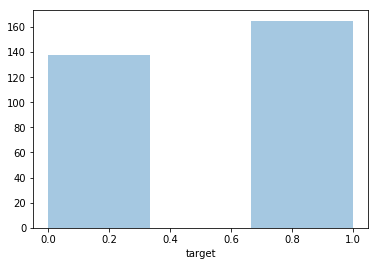

In [3]:
# Check response equality
sns.distplot(dataset[response], kde=False, bins=3)
precent_target_1 = len(np.where(dataset[response] == 1)[0]) / len(dataset[response])
precent_target_0 = len(np.where(dataset[response] == 0)[0]) / len(dataset[response])
print("Percentile of target == 1: {:.2f}%".format(precent_target_1))
print("Percentile of target == 0: {:.2f}%".format(precent_target_0))

### This dataset response is quite balanced (8% different), therefore, **accuracy** can be used measure model performance.

# 2. Split train test

In [4]:
# Train-test split
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset[response])

# Predictors-response split
#train_set = pd.DataFrame(train_set.values, columns=train_set.columns)
y_train = train_set[response]
x_train = train_set.drop([response], axis=1)

#test_set = pd.DataFrame(test_set.values, columns=test_set.columns)
y_test = test_set[response]
x_test = test_set.drop([response], axis=1)

print("train_set: {}".format(train_set.shape))
print("test_set: {}".format(test_set.shape))

train_set: (242, 14)
test_set: (61, 14)


# 3. Get default accuracy

Default score
Train set accuracy: 84.71%
Validation set accuracy: 82.68%
R_squared: 38.33%


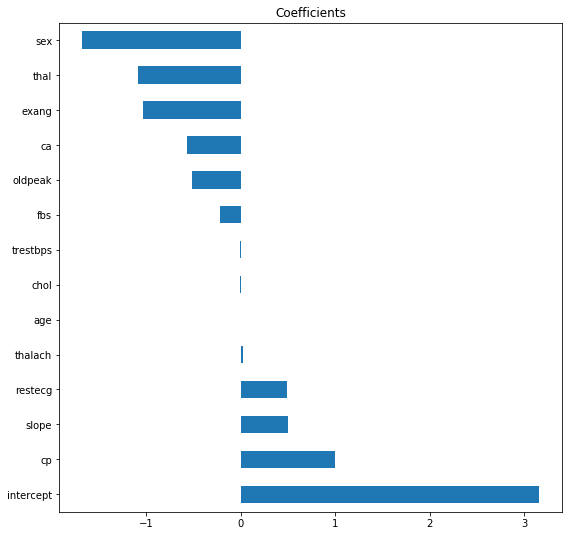

intercept    3.152252
cp           0.995188
slope        0.500806
restecg      0.486181
thalach      0.027461
age          0.006024
chol        -0.010847
trestbps    -0.012743
fbs         -0.219620
oldpeak     -0.520789
ca          -0.573694
exang       -1.037627
thal        -1.089483
sex         -1.680361
dtype: float64

In [5]:
# Fit logistic regression model to dataset without using regularization
logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=100000)

print("Default score")
evaluation(logis_reg, x_train, y_train)

# 4. Preprocessing data

## 4.1 Numerical

In [6]:
std_scaler = StandardScaler()

std_scaler.fit(x_train[numerical_features])

x_numerical = std_scaler.transform(x_train[numerical_features])
x_numerical = pd.DataFrame(x_numerical, columns=numerical_features, dtype="float64")

## 4.2 Categorical

In [7]:
encoder = OneHotEncoder(categories="auto", drop="first")

encoder.fit(x_train[categorical_features])

x_categorical = encoder.transform(x_train[categorical_features])

# Get feature names
feature_names = encoder.get_feature_names(categorical_features)
# Remove dropped columns
feature_names = [feature_name for feature_name in encoder.get_feature_names(categorical_features) if "_0" not in feature_name]

x_categorical = pd.DataFrame(x_categorical.toarray(), columns=feature_names, dtype="int8")

## 4.3 Merge

In [8]:
x_train_processed = pd.concat([x_numerical, x_categorical], axis=1)

# Create polynomial features
x_train_polynomial = create_polynomial(x_train_processed[numerical_features], degree=2, interaction=False)
x_train_polynomial = pd.concat([x_train_processed, x_train_polynomial], axis=1)

x_train_mix = create_polynomial(x_train_processed[numerical_features], degree=2, interaction=True)
x_train_mix = pd.concat([x_train_processed, x_train_mix], axis=1)

Using processed data
Train set accuracy: 88.02%
Validation set accuracy: 83.52%
R_squared: 51.67%


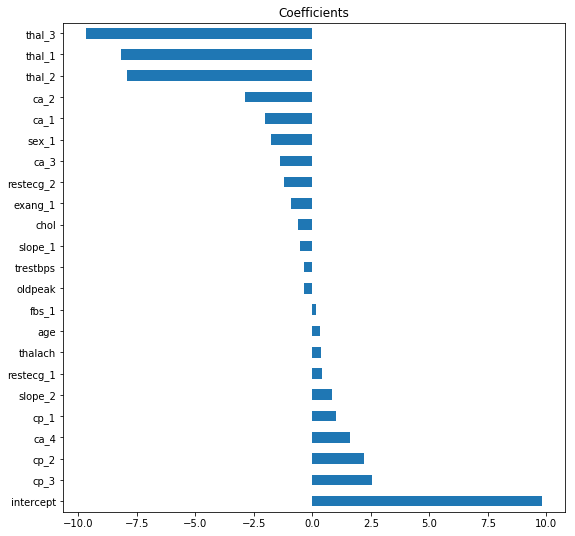

In [9]:
# Fit logistic regression model to dataset without using regularization
logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=100000)

print("Using processed data")
coef = evaluation(logis_reg, x_train_processed, y_train)

# 5. Check collinearity

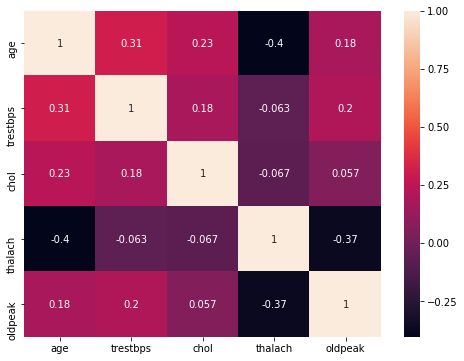

In [10]:
plt.subplots(figsize=(8, 6))
sns.heatmap(x_numerical.corr(), annot=True)
plt.show()

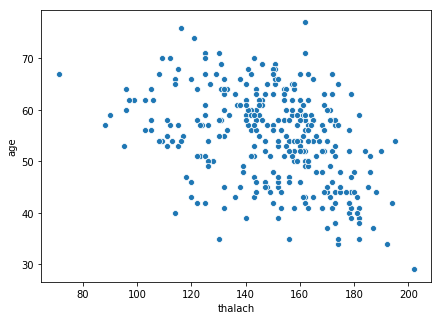

In [11]:
# -0.4 thalach correlate to age
plt.subplots(figsize=(7, 5))
sns.scatterplot(x="thalach", y="age", data=dataset[["age", "thalach"]])
plt.show()

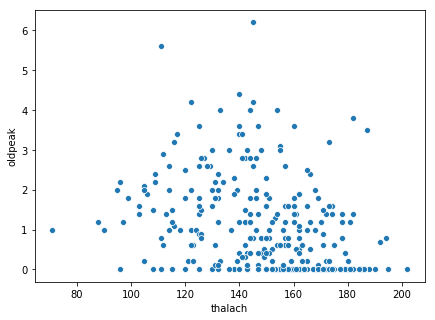

In [12]:
# -0.34 thalach correlate to oldpeak
plt.subplots(figsize=(7, 5))
sns.scatterplot(x="thalach", y="oldpeak", data=dataset[["oldpeak", "thalach"]])
plt.show()

### There is no collinearity in numerical predictors.

# 7. Feature selection

## 7.1 Using Tree's feature important

In [13]:
# Get best parameter for random forst model
param_grid = {"n_estimators": list(range(10, 100, 2))}
forest_clf = RandomForestClassifier(random_state=42)

clf = GridSearchCV(forest_clf, param_grid, cv=10, scoring="accuracy")
clf.fit(x_train, y_train)
print("Best param: {}".format(clf.best_params_))
print("Best score: {}".format(clf.best_score_))

Best param: {'n_estimators': 70}
Best score: 0.8181818181818182


/home/teakatz/.conda/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


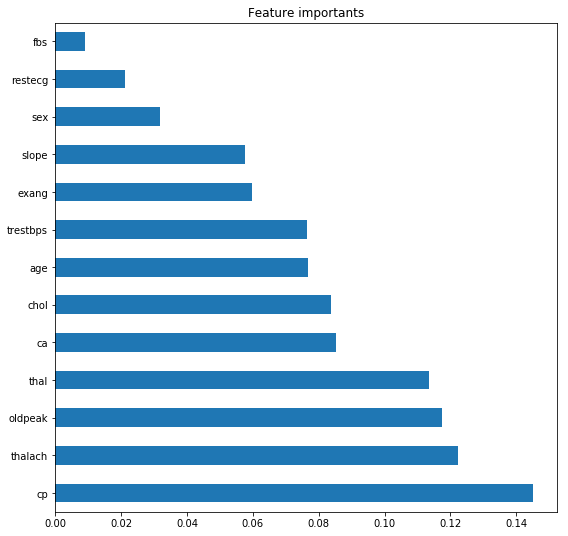

In [14]:
# Get important festures
feature_importants = pd.Series(clf.best_estimator_.feature_importances_, index=x_train.columns)
feature_importants_sorted = feature_importants.sort_values(ascending=False)
feature_importants_sorted.plot(kind="barh", figsize=(9, 9))
plt.title("Feature importants")
plt.show()

## 7.2 Using Subset selection

### 7.2.1 Best subset selection

### 7.2.2 Forward stepwise selection

['thal_2', 'thalach', 'oldpeak', 'cp_2', 'ca_1', 'cp_3', 'trestbps', 'restecg_1', 'ca_2', 'ca_4']
Train set accuracy: 87.19%
Validation set accuracy: 83.50%
R_squared: 48.33%


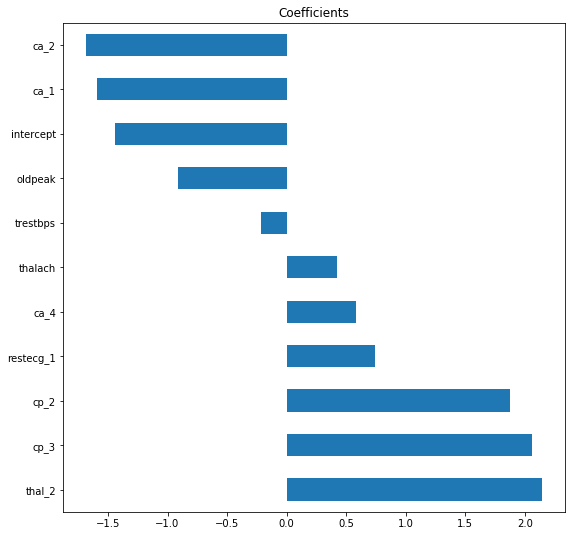

In [15]:
features = forward_selection(x_train_polynomial, y_train, keep_first=True)
print(features)

logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
_ = evaluation(logis_reg, x_train_polynomial[features], y_train)

['thal_2', 'oldpeak^2', 'cp_2', 'slope_1', 'sex_1', 'ca_4', 'cp_3', 'ca_1', 'age^2', 'restecg_2', 'chol^2', 'cp_1', 'thalach^2', 'oldpeak', 'fbs_1', 'ca_2', 'thal_3']
Train set accuracy: 88.43%
Validation set accuracy: 84.32%
R_squared: 53.33%


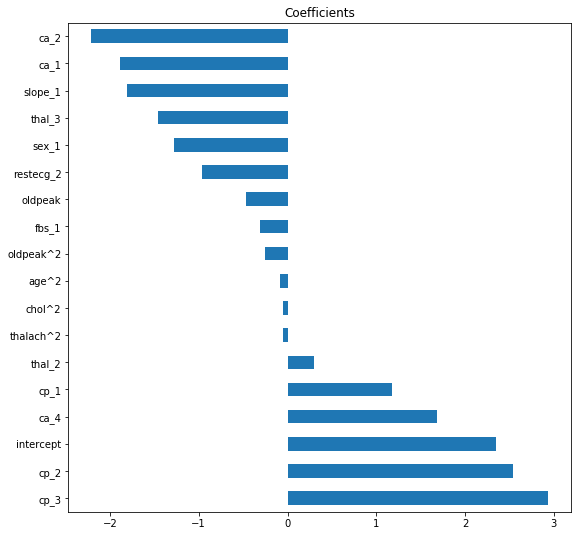

In [16]:
features = forward_selection(x_train_polynomial, y_train, keep_first=False)
print(features)

logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
_ = evaluation(logis_reg, x_train_polynomial[features], y_train)

### 7.2.3 Backward stepwise selection

['age', 'trestbps', 'thalach', 'oldpeak', 'exang_1', 'fbs_1', 'sex_1', 'cp_1', 'cp_2', 'cp_3', 'restecg_1', 'slope_1', 'ca_1', 'ca_2', 'ca_3', 'thal_3', 'oldpeak^2']
Train set accuracy: 88.84%
Validation set accuracy: 86.38%
R_squared: 55.00%


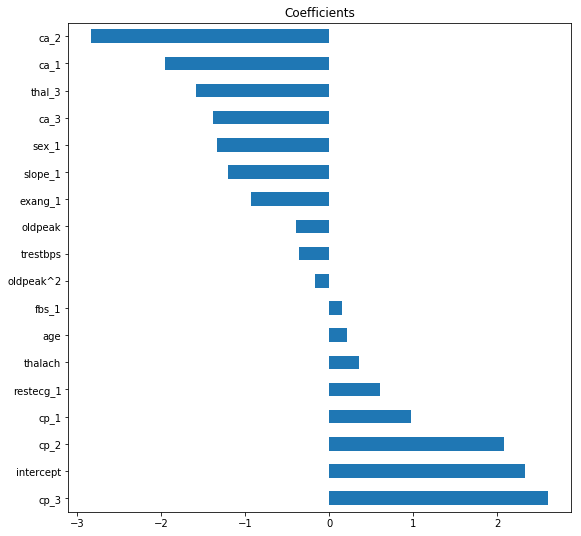

In [17]:
features = backward_selection(x_train_polynomial, y_train, keep_first=True)
print(features)

logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
_ = evaluation(logis_reg, x_train_polynomial[features], y_train)

['trestbps', 'oldpeak', 'exang_1', 'sex_1', 'cp_2', 'cp_3', 'slope_1', 'ca_1', 'thal_3', 'oldpeak^2']
Train set accuracy: 89.67%
Validation set accuracy: 87.67%
R_squared: 58.33%


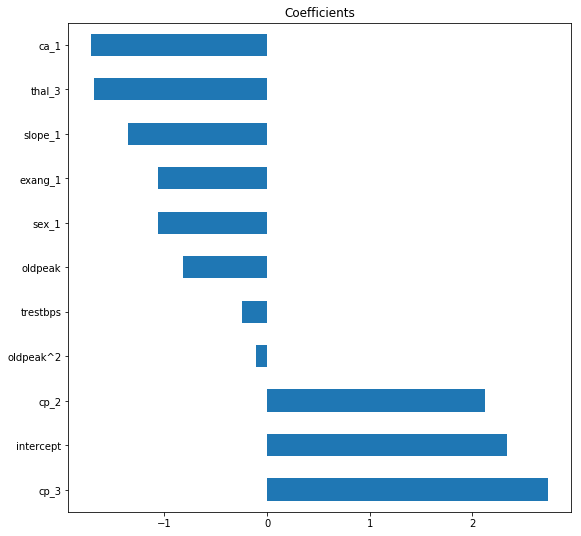

In [18]:
features = backward_selection(x_train_polynomial, y_train, keep_first=False)
print(features)

logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
_ = evaluation(logis_reg, x_train_polynomial[features], y_train)

### 7.2.4 Hybrid appoaches

['thalach', 'oldpeak', 'cp_2', 'ca_1', 'cp_3', 'restecg_1', 'ca_2', 'ca_4', 'age^2', 'thal_1', 'restecg_2', 'slope_2', 'fbs_1', 'chol^2', 'thalach^2', 'thal_2', 'ca_3', 'sex_1', 'slope_1', 'chol', 'thal_3']
Train set accuracy: 90.08%
Validation set accuracy: 84.73%
R_squared: 60.00%


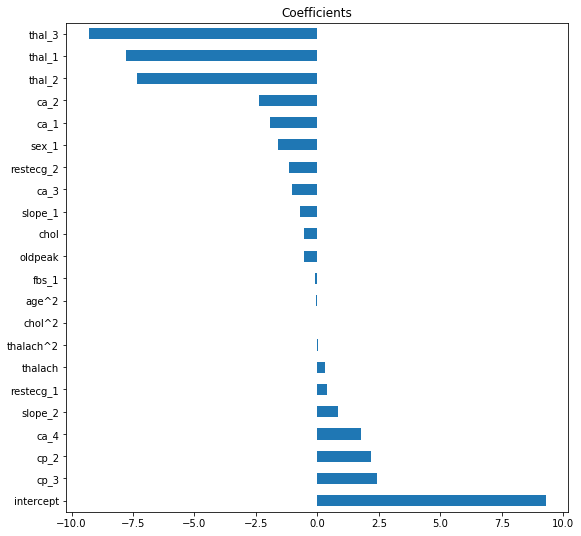

cp_2
match: 58/71 (81.69%)
invert_match: 13/71 (18.31%)
-----------------------
ca_1
match: 19/55 (34.55%)
invert_match: 36/55 (65.45%)
-----------------------
cp_3
match: 11/15 (73.33%)
invert_match: 4/15 (26.67%)
-----------------------
restecg_1
match: 79/124 (63.71%)
invert_match: 45/124 (36.29%)
-----------------------
ca_2
match: 5/27 (18.52%)
invert_match: 22/27 (81.48%)
-----------------------
ca_4
match: 4/5 (80.00%)
invert_match: 1/5 (20.00%)
-----------------------
thal_1
match: 4/14 (28.57%)
invert_match: 10/14 (71.43%)
-----------------------
restecg_2
match: 1/4 (25.00%)
invert_match: 3/4 (75.00%)
-----------------------
slope_2
match: 90/117 (76.92%)
invert_match: 27/117 (23.08%)
-----------------------
fbs_1
match: 17/34 (50.00%)
invert_match: 17/34 (50.00%)
-----------------------
thal_2
match: 104/129 (80.62%)
invert_match: 25/129 (19.38%)
-----------------------
ca_3
match: 3/17 (17.65%)
invert_match: 14/17 (82.35%)
-----------------------
sex_1
match: 76/165 (46.06%

In [19]:
features = forward_backward_selection(x_train_polynomial, y_train, keep_first=True)
print(features)

logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
_ = evaluation(logis_reg, x_train_polynomial[features], y_train)

for feature in features:
    if "_" in feature:
        print(feature)
        compare_categorical(x_train_polynomial[feature], y_train)
        print("-----------------------")

['thal_2', 'thalach', 'oldpeak', 'cp_2', 'ca_1', 'cp_3', 'trestbps', 'ca_2', 'age', 'thal_1', 'thal_3', 'fbs_1', 'slope_2', 'restecg_2', 'ca_3', 'cp_1', 'slope_1', 'exang_1']
Train set accuracy: 89.26%
Validation set accuracy: 84.77%
R_squared: 56.67%


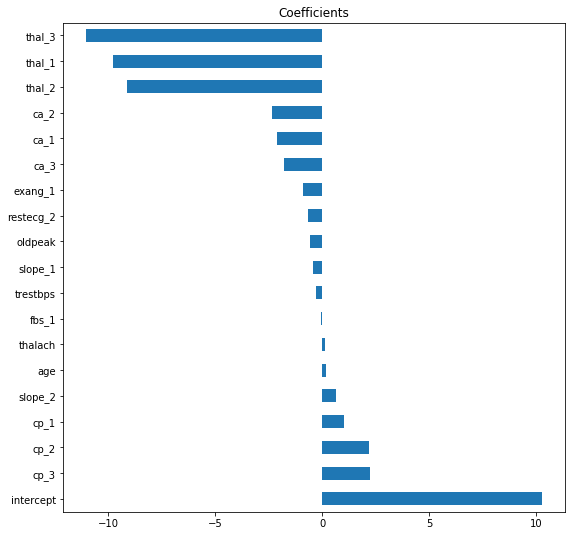

In [20]:
features = forward_backward_selection(x_train_processed, y_train, keep_first=True)
print(features)

logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
coef_1 = evaluation(logis_reg, x_train_processed[features], y_train)

## 7.3 Using l1 regularization

In [21]:
# Get best parameter for random forst model
param_grid = {"C": list(range(1, 100, 1))}
logis_reg = LogisticRegression(penalty="l1" ,solver="saga", max_iter=100000)

clf = GridSearchCV(logis_reg, param_grid, cv=10, scoring="accuracy")
clf.fit(x_train_polynomial, y_train)
print("Best param: {}".format(clf.best_params_))
print("Best score: {}".format(clf.best_score_))

Best param: {'C': 3}
Best score: 0.8388429752066116


/home/teakatz/.conda/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set accuracy: 88.02%
Validation set accuracy: 83.95%
R_squared: 51.67%


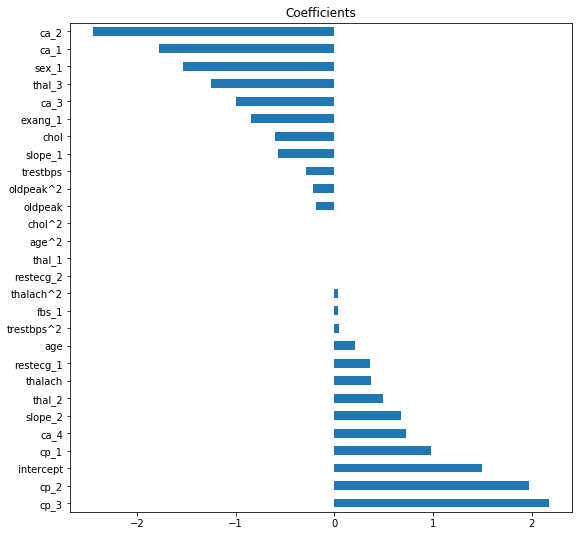

cp_3          2.178819
cp_2          1.972199
intercept     1.496004
cp_1          0.983181
ca_4          0.722739
slope_2       0.678635
thal_2        0.495362
thalach       0.372339
restecg_1     0.364300
age           0.207734
trestbps^2    0.046212
fbs_1         0.038705
thalach^2     0.035488
restecg_2     0.000000
thal_1        0.000000
age^2         0.000000
chol^2        0.000000
oldpeak      -0.186803
oldpeak^2    -0.211650
trestbps     -0.282808
slope_1      -0.569987
chol         -0.602934
exang_1      -0.840957
ca_3         -0.996249
thal_3       -1.248755
sex_1        -1.531263
ca_1         -1.776611
ca_2         -2.448581
dtype: float64

In [22]:
logis_reg = LogisticRegression(penalty="l1" ,solver="saga", C=4, max_iter=100000)
evaluation(logis_reg, x_train_polynomial, y_train)